# Fraud Detection in Credit Card Transactions
## Exploratory Analysis

### Team Members: Lewis, Patrick, Brian

This project aims to identify fraudulent credit card transactions. The dataset is a large dataset with 24,386,900 observations and 14 variables.

This workbook focuses on the exploratory analysis. Resampling is also done to create a smaller subset of the data for modelling (see separate workbook for modelling).

## Loading Libraries

In [1]:
## Dataset manipulation
import pandas as pd 
import numpy as np 

## Visualisation
import seaborn as sns 
import matplotlib.pyplot as plt 

## Setting Plot Styles

In [2]:
%matplotlib inline
plt.style.use('dark_background')

## Writing Functions

### Unique Values Function

In [3]:
def unique_values(df, variable):
    
    """
    Function to print unique values and their counts for a variable
    ----------------------------------------------------------------
    df: dataframe
    variable: name of variable in string
    """
    
    print(f'The variable {variable} has {len(df[variable].unique())} unique values: \n')
    print(f'{df[variable].unique()}')
    print(f'-------------------------------------------------------------------------- \n')

### Missing Values Function

In [4]:
def missing(df):
    
    """
    Function to show the counts of missing values of each variable and their percentages out of the whole dataset
    --------------------------------------------------------------------------------------------------------------
    df: dataframe
    """
    
    variables = df.columns
    missings = df.isnull().sum()
    percent = round(missings/df.shape[0], 3)
    
    result = pd.DataFrame(list(zip(variables, missings, percent)))
    result.columns = ['Variables', 'Count', 'Percentage']
    result = result.sort_values(by = 'Count', ascending = False)
    
    print(result)

### Data Cleaning

In [5]:
def data_clean(df):
    
    """
    Function to clean the dataset
    ------------------------------
    df: dataframe
    """
    
    ## Cleaning Amount and converting to float
    df['Amount'] = df['Amount'].apply(lambda x: float(x[1:]))
    
    ## Cleaning Errors? 
    df['Errors?'].fillna('None',inplace = True)
    
    return df

### Feature Engineering

In [6]:
def data_eng(df):
    
    """
    Function to perform data engineering on the dataset
    -----------------------------------------------------
    df: dataframe
    """
    
    ## Combining Year and Month
    df['Year_month'] = df['Year'] + df['Month']/(12)
    
    ## Counting number of errors in a transaction
    df['Error_count'] = df['Errors?'].apply(lambda x: x.count(','))
    
    ## Grouping MCC into categories
    mcc_dict = dict([(i,'Agriculture') for i in range(1, 1499)] +
                [(i,'Contracted') for i in range(1500, 2999)] + 
                [(i,'Airlines') for i in range(3000, 3299)] +
                [(i, 'Car Rental') for i in range(3300, 3499)] + 
                [(i, 'Lodging') for i in range(3500, 3999)] + 
                [(i, 'Transportation') for i in range(4000, 4799)] + 
                [(i, 'Utility') for i in range(4800, 4999)] + 
                [(i, 'Retail_outlet') for i in range(5000, 5599)] + 
                [(i, 'Clothing') for i in range(5600, 5699)] + 
                [(i, 'Miscellaneous') for i in range(5700, 7299)] + 
                [(i, 'Business_service') for i in range(7300, 7999)] + 
                [(i, 'Professional_membership') for i in range(8000, 8999)] + 
                [(i, 'Government') for i in range(9000, 9999)]
               )
    
    df['Business_type'] = df['MCC'].map(mcc_dict)
    
    ## Compute median spending of each user and the difference
    median_spending = df.groupby(['User'])['Amount'].median().reset_index()
    median_spending_dict = median_spending.to_dict()['Amount']
    
    df['User_median_Amount'] = df['User'].map(median_spending_dict)
    df['Med_price_differential'] = abs(df['Amount'] - df['User_median_Amount'])
    
    ## Extract hours from Time
    df['Hour'] = df['Time'].str[:2]
    df['Minute'] = df['Time'].str[3:]
    df['DateTime'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour', 'Minute']])

    ## Convert Hour to Int
    df['Hour'] = df['Hour'].astype(int)
    
    return df

## Reading in Data

### Full Dataset

In [7]:
full_credit = pd.read_csv('OneDrive/Desktop/Digital_Futures/Digital_Futures_Group_Project_4/full_card_transactions.csv')

## Inspecting Data

In [8]:
full_credit.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN


In [9]:
print(f'Number of observations: {full_credit.shape[0]}')
print(f'Number of variables: {full_credit.shape[1]}')

Number of observations: 24386900
Number of variables: 14


In [10]:
full_credit.dtypes

User                int64
Card                int64
Year                int64
Month               int64
Day                 int64
Time               object
Amount             object
Use Chip           object
Merchant Name       int64
Merchant City      object
Merchant State     object
Zip               float64
MCC                 int64
Errors?            object
dtype: object

In [11]:
missing(full_credit)

         Variables     Count  Percentage
13         Errors?  23998469       0.984
11             Zip   2878135       0.118
10  Merchant State   2720821       0.112
0             User         0       0.000
1             Card         0       0.000
2             Year         0       0.000
3            Month         0       0.000
4              Day         0       0.000
5             Time         0       0.000
6           Amount         0       0.000
7         Use Chip         0       0.000
8    Merchant Name         0       0.000
9    Merchant City         0       0.000
12             MCC         0       0.000


In [12]:
full_credit.describe()

,User,Card,Year,Month,Day,Merchant Name,Zip,MCC
count,2.438690e+07,2.438690e+07,2.438690e+07,2.438690e+07,2.438690e+07,2.438690e+07,2.150876e+07,2.438690e+07
mean,1.001019e+03,1.351366e+00,2.011955e+03,6.525064e+00,1.571812e+01,-4.769230e+17,5.095644e+04,5.561171e+03
std,5.694612e+02,1.407154e+00,5.105921e+00,3.472355e+00,8.794073e+00,4.758940e+18,2.939707e+04,8.793154e+02
min,0.000000e+00,0.000000e+00,1.991000e+03,1.000000e+00,1.000000e+00,-9.222899e+18,5.010000e+02,1.711000e+03
25%,5.100000e+02,0.000000e+00,2.008000e+03,3.000000e+00,8.000000e+00,-4.500543e+18,2.837400e+04,5.300000e+03
50%,1.006000e+03,1.000000e+00,2.013000e+03,7.000000e+00,1.600000e+01,-7.946765e+17,4.674200e+04,5.499000e+03
75%,1.477000e+03,2.000000e+00,2.016000e+03,1.000000e+01,2.300000e+01,3.189517e+18,7.756400e+04,5.812000e+03
max,1.999000e+03,8.000000e+00,2.020000e+03,1.200000e+01,3.100000e+01,9.223292e+18,9.992800e+04,9.402000e+03


In [13]:
for i in full_credit.columns:
    unique_values(full_credit, i)

The variable User has 2000 unique values: 

[   0    1    2 ... 1997 1998 1999]
-------------------------------------------------------------------------- 

The variable Card has 9 unique values: 

[0 1 2 3 4 5 6 7 8]
-------------------------------------------------------------------------- 

The variable Year has 30 unique values: 

[2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017 2018 2019 2020 1999 2000 2001 1998 1996 1997 1995 1994 1991
 1992 1993]
-------------------------------------------------------------------------- 

The variable Month has 12 unique values: 

[ 9 10 11 12  1  2  3  4  5  6  7  8]
-------------------------------------------------------------------------- 

The variable Day has 31 unique values: 

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
-------------------------------------------------------------------------- 

The variable Time has 1440 unique values: 

['06:21' '06:42'

In [14]:
full_credit['Errors?'].value_counts()

Insufficient Balance,                                   242783
Bad PIN,                                                 58918
Technical Glitch,                                        48157
Bad Card Number,                                         13321
Bad CVV,                                                 10740
Bad Expiration,                                          10716
Bad Zipcode,                                              2079
Bad PIN,Insufficient Balance,                              581
Insufficient Balance,Technical Glitch,                     457
Bad PIN,Technical Glitch,                                  128
Bad Card Number,Insufficient Balance,                      122
Bad CVV,Insufficient Balance,                               89
Bad Expiration,Insufficient Balance,                        78
Bad Card Number,Bad CVV,                                    60
Bad Card Number,Bad Expiration,                             54
Bad Expiration,Bad CVV,                                

## Data Cleaning

In [15]:
full_credit = data_clean(full_credit)

## Feature Engineering

In [16]:
full_credit = data_eng(full_credit)

In [17]:
full_credit.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,...,MCC,Errors?,Year_month,Error_count,Business_type,User_median_Amount,Med_price_differential,Hour,Minute,DateTime
0,0,0,2002,9,1,06:21,134.09,Swipe Transaction,3527213246127876953,La Verne,...,5300,None,2002.75,0,Retail_outlet,69.45,64.64,6,21,2002-09-01 06:21:00
1,0,0,2002,9,1,06:42,38.48,Swipe Transaction,-727612092139916043,Monterey Park,...,5411,None,2002.75,0,Retail_outlet,69.45,30.97,6,42,2002-09-01 06:42:00
2,0,0,2002,9,2,06:22,120.34,Swipe Transaction,-727612092139916043,Monterey Park,...,5411,None,2002.75,0,Retail_outlet,69.45,50.89,6,22,2002-09-02 06:22:00
3,0,0,2002,9,2,17:45,128.95,Swipe Transaction,3414527459579106770,Monterey Park,...,5651,None,2002.75,0,Clothing,69.45,59.50,17,45,2002-09-02 17:45:00
4,0,0,2002,9,3,06:23,104.71,Swipe Transaction,5817218446178736267,La Verne,...,5912,None,2002.75,0,Miscellaneous,69.45,35.26,6,23,2002-09-03 06:23:00


## EDA

### 5 Most Common States

In [18]:
full_credit['Merchant State'].value_counts().head()

CA    2591830
TX    1793298
FL    1458699
NY    1446864
OH     895970
Name: Merchant State, dtype: int64

### 5 Most Common Cities

In [19]:
full_credit['Merchant City'].value_counts().head()

ONLINE         2720821
Houston         246036
Los Angeles     180496
Miami           178653
Brooklyn        155425
Name: Merchant City, dtype: int64

### Distribution of Transaction Method

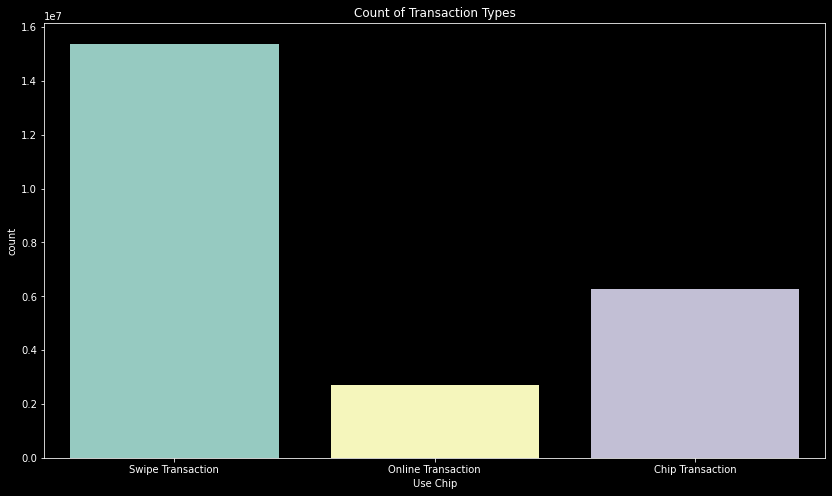

In [20]:
plt.figure(figsize = (14, 8))
sns.countplot(x = full_credit['Use Chip'])
plt.title('Count of Transaction Types')
plt.show()

In [21]:
full_credit['Use Chip'].value_counts()

Swipe Transaction     15386082
Chip Transaction       6287598
Online Transaction     2713220
Name: Use Chip, dtype: int64

In [22]:
full_credit.groupby(['Use Chip'])['Error_count'].sum()

Use Chip
Chip Transaction       94253
Online Transaction     62020
Swipe Transaction     233878
Name: Error_count, dtype: int64

### Transaction Amount of Each Category

In [23]:
transactions_category = full_credit.groupby('Business_type')['Amount'].count().sort_values(ascending = False).reset_index()

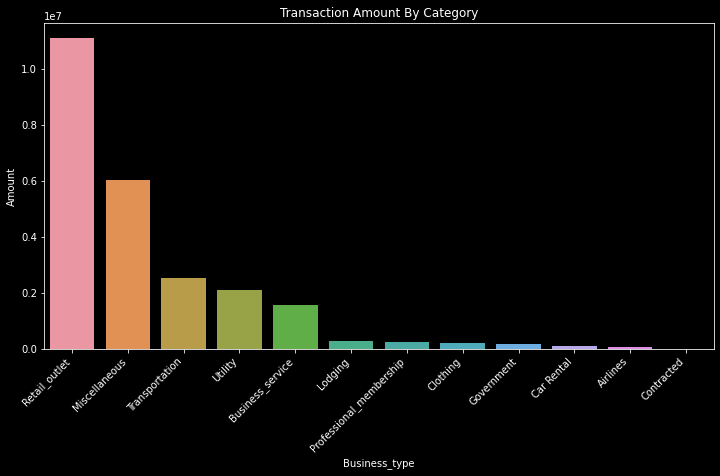

In [24]:
plt.figure(figsize = (12, 6))

sns.barplot(x = 'Business_type',
            y = 'Amount',
            data = transactions_category)

plt.xticks(rotation = 45,
           horizontalalignment='right',
           fontweight ='light',
           fontsize ='medium'
           )

plt.title('Transaction Amount By Category')

plt.savefig('OneDrive/Desktop/Digital_Futures/Digital_Futures_Group_Project_4/Transactions_category.png', 
            bbox_inches = 'tight')

plt.show()

### Average Spending of Each Category

In [25]:
avg_spending_category = full_credit.groupby('Business_type')['Amount'].mean().sort_values(ascending = False).reset_index()

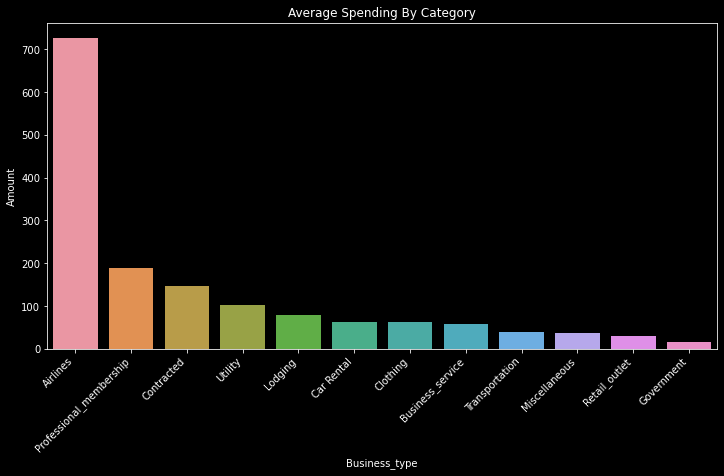

In [26]:
plt.figure(figsize = (12, 6))

sns.barplot(x = 'Business_type',
            y = 'Amount',
            data = avg_spending_category)

plt.xticks(rotation = 45,
           horizontalalignment='right',
           fontweight ='light',
           fontsize ='medium'
           )

plt.title('Average Spending By Category')

plt.savefig('OneDrive/Desktop/Digital_Futures/Digital_Futures_Group_Project_4/Average_spending_category.png', 
            bbox_inches = 'tight')

plt.show()

### Number of Errors Per Transaction Type

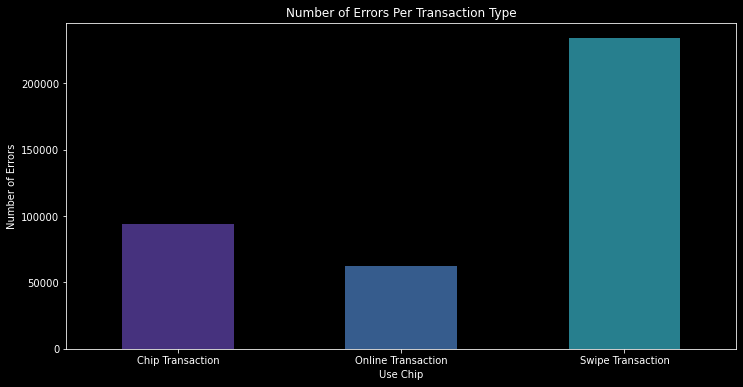

In [27]:
plt.figure(figsize = (12, 6))

full_credit.groupby(['Use Chip'])['Error_count'].sum().plot.bar(color = sns.color_palette('viridis'))

plt.xticks(rotation = 0)

plt.title('Number of Errors Per Transaction Type')

plt.ylabel('Number of Errors')

plt.show()

### Top 3 Cities with the Most Transactions

In [28]:
top_city = full_credit.groupby('Merchant City')['User'].count().sort_values(ascending = False).reset_index()

In [29]:
## Removing online transactions
top_city = top_city.iloc[1:4, ]

In [30]:
top_city.columns = ['Merchant City', 'Number of transactions']

In [31]:
top_city

,Merchant City,Number of transactions
1,Houston,246036
2,Los Angeles,180496
3,Miami,178653


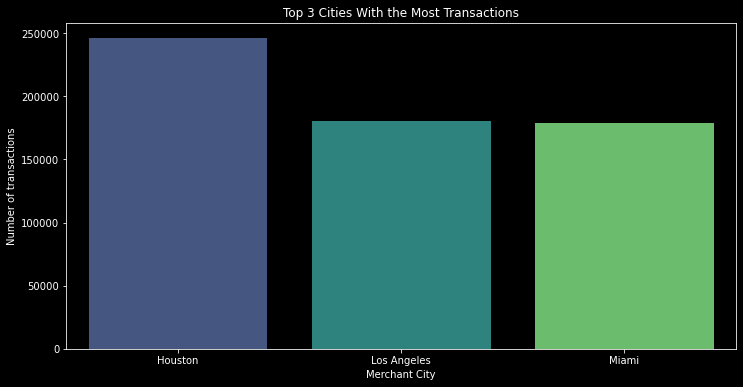

In [32]:
plt.figure(figsize = (12, 6))

sns.barplot(x = 'Merchant City',
            y = 'Number of transactions',
            data = top_city,
            palette = 'viridis')

plt.title('Top 3 Cities With the Most Transactions')

plt.savefig('OneDrive/Desktop/Digital_Futures/Digital_Futures_Group_Project_4/city_top_transactions.png')

plt.show()

### Distribution of the Number of Cards

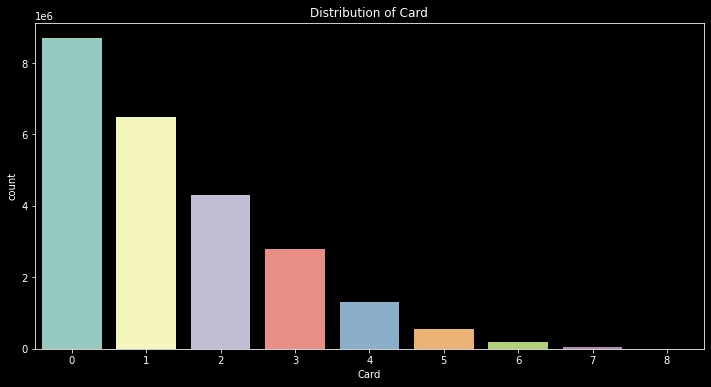

In [33]:
plt.figure(figsize = (12, 6))

sns.countplot(x = 'Card',
              data = full_credit)

plt.title('Distribution of Card')

plt.savefig('OneDrive/Desktop/Digital_Futures/Digital_Futures_Group_Project_4/count_card.png')

plt.show()

### Number of Transactions Made By Top 10 Users

In [34]:
user_count = full_credit.groupby('User')['Card'].count().sort_values(ascending = False).reset_index().head(10)

In [35]:
user_count['User'] = user_count['User'].astype("category")

In [36]:
user_count.columns = ['User ID', 'Number of Transactions']

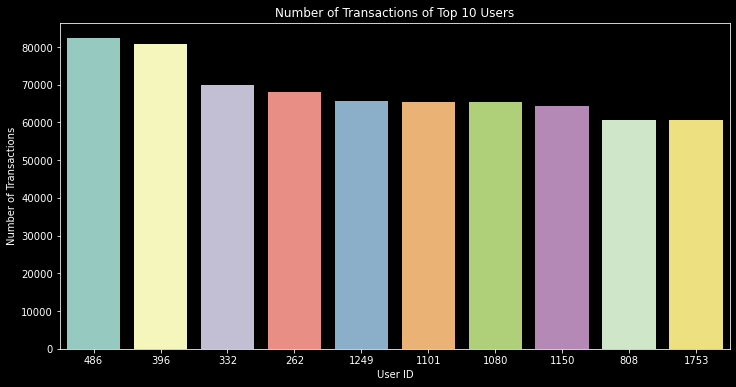

In [37]:
plt.figure(figsize = (12, 6))

sns.barplot(x = 'User ID',
            y = 'Number of Transactions',
            data = user_count,
            order = user_count['User ID'])

plt.title('Number of Transactions of Top 10 Users')

plt.savefig('OneDrive/Desktop/Digital_Futures/Digital_Futures_Group_Project_4/user_count.png', dpi = 500)

plt.show()

### Number of Transactions Per Hours

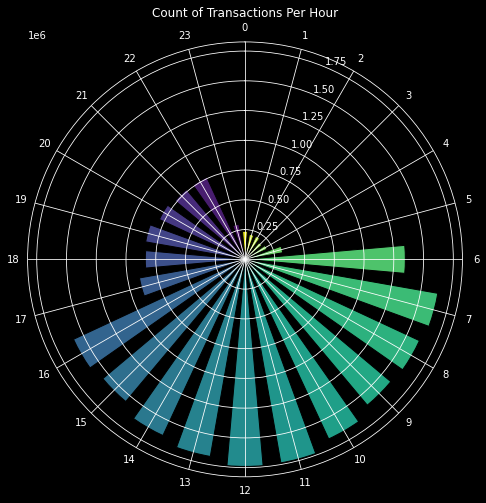

In [38]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, polar = True)

sample = full_credit['Hour'].value_counts(sort = False).to_numpy()
N = len(sample) 

theta = np.arange(0, 2*np.pi, 2*np.pi/N) 
bars = ax.bar(theta, sample, width = 0.175, align = 'center', edgecolor = 'black', color = sns.color_palette('viridis_r', N))

ax.set_xticks(theta)
ax.set_xticklabels(range(len(theta)))
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.yaxis.grid(True)
plt.title('Count of Transactions Per Hour')
plt.savefig('ClockStuff.jpg', bbox_inches = "tight", dpi = 1000)

plt.show()

### Average Transaction Amount Per Year

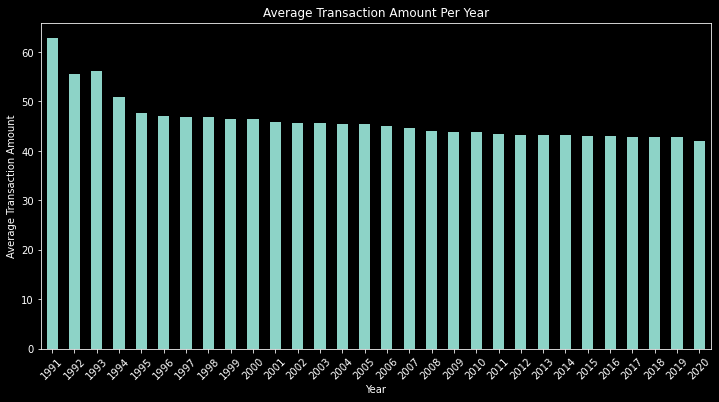

In [39]:
plt.figure(figsize = (12, 6))

full_credit.groupby(['Year'])['Amount'].mean().plot.bar()

plt.xticks(rotation = 45)

plt.title('Average Transaction Amount Per Year')

plt.ylabel('Average Transaction Amount')

plt.show()

### Total Amount of Transactions Per Year

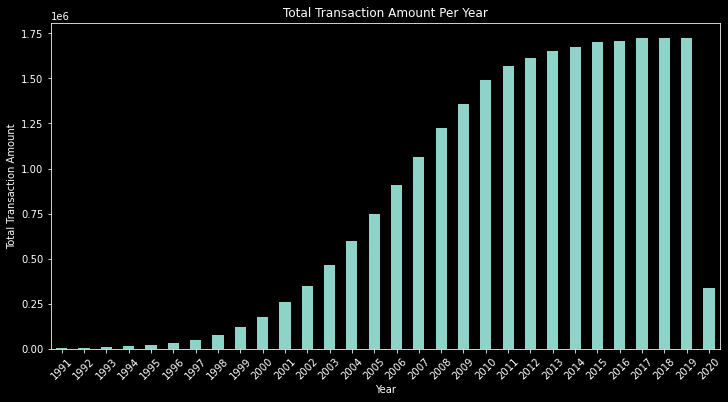

In [40]:
plt.figure(figsize = (12, 6))

full_credit.groupby(['Year'])['Amount'].count().plot.bar()

plt.xticks(rotation = 45)

plt.title('Total Transaction Amount Per Year')

plt.ylabel('Total Transaction Amount')

plt.show()

## Resampling

In [41]:
full_credit_sample = pd.read_csv('OneDrive/Desktop/Digital_Futures/Digital_Futures_Group_Project_4/lpb_sampled_transactions.csv')

In [42]:
full_credit_sample.drop('Unnamed: 0', axis = 1, inplace = True)

### Data Cleaning (sample)

In [43]:
full_credit_sample = data_clean(full_credit_sample)

### Feature Engineering (sample)

In [44]:
full_credit_sample = data_eng(full_credit_sample)

### Checking if Sample Data Statistics Follow Overall Data Statistics

In [45]:
transactions_category_sample = full_credit_sample.groupby('Business_type')['Amount'].count().sort_values(ascending = False).reset_index()

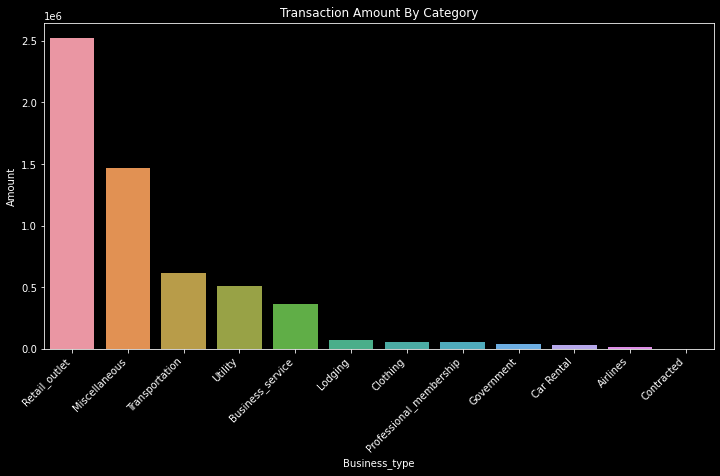

In [46]:
plt.figure(figsize = (12, 6))

sns.barplot(x = 'Business_type',
            y = 'Amount',
            data = transactions_category_sample)

plt.xticks(rotation = 45,
           horizontalalignment='right',
           fontweight ='light',
           fontsize ='medium'
           )

plt.title('Transaction Amount By Category')

plt.show()

In [47]:
full_credit_sample.Amount.describe()

count    5.732218e+06
mean     4.500278e+01
std      8.263442e+01
min     -5.000000e+02
25%      1.016000e+01
50%      3.030000e+01
75%      6.716000e+01
max      5.155360e+03
Name: Amount, dtype: float64